# Bitcoin analysis

bitcoin vs. sp500, and bitcoin vs. coinindex

## Extract BTC data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cryptocmd import CmcScraper
%matplotlib inline

# initialise scraper without time interval
scraper = CmcScraper("BTC")

btc_df = scraper.get_dataframe()
btc_df = pd.DataFrame(btc_df, columns=['Date','Close'])
btc_df.set_index('Date', inplace=True)
btc_df = btc_df.rename(columns = {'Close':'BTC'})
btc_df = btc_df.iloc[::-1]
btc_df.index = btc_df.index.tz_localize("UTC")
btc_df

,BTC
Date,
2013-04-28 00:00:00+00:00,134.210007
2013-04-29 00:00:00+00:00,144.539993
2013-04-30 00:00:00+00:00,139.000000
2013-05-01 00:00:00+00:00,116.989998
2013-05-02 00:00:00+00:00,105.209999
...,...
2022-03-06 00:00:00+00:00,38419.983377
2022-03-07 00:00:00+00:00,38062.040206
2022-03-08 00:00:00+00:00,38737.268495


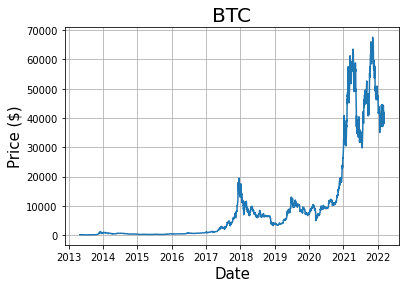

In [2]:
plt.plot(btc_df['BTC'])
plt.xlabel("Date", size=15)
plt.ylabel("Price ($)", size=15)
plt.title("BTC", size=20)
plt.grid()
plt.show()

Date
2013-04-28 00:00:00+00:00    0.000000
2013-04-29 00:00:00+00:00    0.076969
2013-04-30 00:00:00+00:00   -0.038328
2013-05-01 00:00:00+00:00   -0.158345
2013-05-02 00:00:00+00:00   -0.100692
                               ...   
2022-03-06 00:00:00+00:00   -0.024888
2022-03-07 00:00:00+00:00   -0.009317
2022-03-08 00:00:00+00:00    0.017740
2022-03-09 00:00:00+00:00    0.083786
2022-03-10 00:00:00+00:00   -0.060631
Name: BTC, Length: 3239, dtype: float64

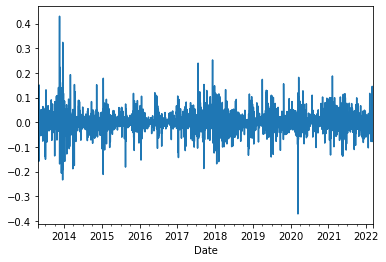

In [3]:
btc_daily_return = btc_df.pct_change().fillna(0).squeeze()
btc_daily_return.plot()
btc_daily_return

## Extract Coin Index

Use the first 10 cryptocurrency to build the coin index : $CoinIndex = \sum_{i=1}^{10}{Price_i \frac{MarketCap_i}{TotalCap}}$

In [4]:
top_10_coins = ['BTC', 'ETH', 'USDT', 'BNB', 'USDC', 'XRP', 'LUNA', 'ADA', 'SOL', 'AVAX']

def scraper_top_10_coins(top_10_coins):
    all_coins_df = pd.DataFrame(columns=['Date'])
    for coins in top_10_coins:
        scraper = CmcScraper(coins)
        coins_df = scraper.get_dataframe()
        coins_df = pd.DataFrame(coins_df, columns=['Date','Close', 'Market Cap'])
        coins_df = coins_df.rename(columns = {'Close':coins+' Close'})
        coins_df = coins_df.rename(columns = {'Market Cap':coins+' Market Cap'})
        all_coins_df = all_coins_df.merge(coins_df, on='Date', how='outer')
    
    all_coins_df.set_index('Date', inplace=True)
    all_coins_df = all_coins_df.fillna(0)
    all_coins_df = all_coins_df.iloc[::-1]
    all_coins_df.index = all_coins_df.index.tz_localize("UTC")
    return all_coins_df

all_coins_df = scraper_top_10_coins(top_10_coins)
all_coins_df

,BTC Close,BTC Market Cap,ETH Close,ETH Market Cap,USDT Close,USDT Market Cap,BNB Close,BNB Market Cap,USDC Close,USDC Market Cap,XRP Close,XRP Market Cap,LUNA Close,LUNA Market Cap,ADA Close,ADA Market Cap,SOL Close,SOL Market Cap,AVAX Close,AVAX Market Cap
Date,,,,,,,,,,,,,,,,,,,,
2013-04-28 00:00:00+00:00,134.210007,1.488567e+09,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
2013-04-29 00:00:00+00:00,144.539993,1.603769e+09,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
2013-04-30 00:00:00+00:00,139.000000,1.542813e+09,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
2013-05-01 00:00:00+00:00,116.989998,1.298955e+09,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
2013-05-02 00:00:00+00:00,105.209999,1.168517e+09,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-06 00:00:00+00:00,38419.983377,7.290624e+11,2555.037441,3.062294e+11,1.000244,7.973253e+10,375.011193,6.192063e+10,0.999851,5.283850e+10,0.725994,3.481089e+10,79.115772,2.911464e+10,0.823752,2.773938e+10,84.542186,2.711515e+10,72.529022,1.926714e+10
2022-03-07 00:00:00+00:00,38062.040206,7.223057e+11,2497.771320,2.993998e+11,1.000123,8.003290e+10,381.344622,6.296639e+10,0.999134,5.241194e+10,0.723287,3.467745e+10,77.942748,2.856299e+10,0.797379,2.685126e+10,82.130069,2.638176e+10,71.880536,1.910380e+10
2022-03-08 00:00:00+00:00,38737.268495,7.351563e+11,2576.747612,3.089016e+11,1.000282,8.005216e+10,381.958563,6.306776e+10,1.000260,5.244599e+10,0.720977,3.456674e+10,85.498712,3.117752e+10,0.801250,2.698159e+10,82.254762,2.616062e+10,72.918359,1.938643e+10


In [5]:
all_coins_df['Total Market Map'] = all_coins_df.loc[:, all_coins_df.columns.str.endswith('Market Cap')].sum(1)
all_coins_df['CoinIndex'] = np.zeros(len(all_coins_df))

def weighted_coins_index(top_10_coins, all_coins_df):
    for coins in top_10_coins:
        all_coins_df['CoinIndex'] = all_coins_df['CoinIndex'] + all_coins_df.apply(lambda x: x[coins+' Close'] * x[coins+' Market Cap'] / x['Total Market Map'], axis=1)
    
    return all_coins_df

weighted_coins_df = weighted_coins_index(top_10_coins, all_coins_df)
weighted_coins_df = weighted_coins_df.iloc[: , -1]
weighted_coins_df

Date
2013-04-28 00:00:00+00:00      134.210007
2013-04-29 00:00:00+00:00      144.539993
2013-04-30 00:00:00+00:00      139.000000
2013-05-01 00:00:00+00:00      116.989998
2013-05-02 00:00:00+00:00      105.209999
                                 ...     
2022-03-06 00:00:00+00:00    21071.604837
2022-03-07 00:00:00+00:00    20899.196197
2022-03-08 00:00:00+00:00    21267.492667
2022-03-09 00:00:00+00:00    23352.152308
2022-03-10 00:00:00+00:00    21678.202167
Name: CoinIndex, Length: 3239, dtype: float64

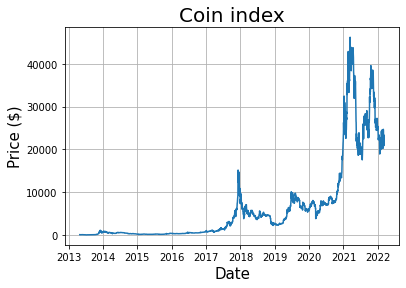

In [6]:
plt.plot(weighted_coins_df)
plt.xlabel("Date", size=15)
plt.ylabel("Price ($)", size=15)
plt.title("Coin index", size=20)
plt.grid()
plt.show()

count    3239.000000
mean        0.002559
std         0.044531
min        -0.379268
25%        -0.015088
50%         0.001018
75%         0.019293
max         0.434503
Name: CoinIndex, dtype: float64

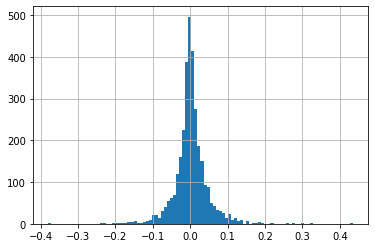

In [19]:
weighted_coins_return = weighted_coins_df.pct_change().fillna(0).squeeze()
weighted_coins_return.hist(bins=100)
weighted_coins_return.describe()

## Extract SP500 data



In [8]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2013, 4, 27)
end = datetime.datetime(2022, 3, 9)
SP500 = web.DataReader(['sp500'], 'fred', start, end)
SP500=SP500.rename(columns = {'sp500':'SP500'})
SP500.index = SP500.index.tz_localize("UTC")
SP500

,SP500
DATE,
2013-04-29 00:00:00+00:00,1593.61
2013-04-30 00:00:00+00:00,1597.57
2013-05-01 00:00:00+00:00,1582.70
2013-05-02 00:00:00+00:00,1597.59
2013-05-03 00:00:00+00:00,1614.42
...,...
2022-03-03 00:00:00+00:00,4363.49
2022-03-04 00:00:00+00:00,4328.87
2022-03-07 00:00:00+00:00,4201.09


<AxesSubplot:title={'center':'S&P 500 Price'}, xlabel='DATE'>

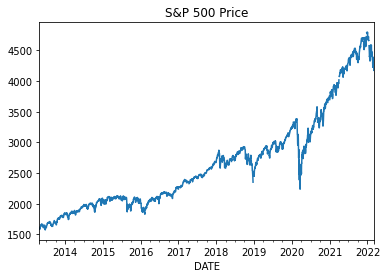

In [9]:
SP500['SP500'].plot(title='S&P 500 Price')

<AxesSubplot:xlabel='DATE'>

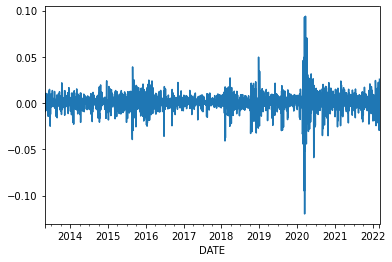

In [10]:
sp500_daily_return = SP500['SP500'].pct_change(1).fillna(0)
sp500_daily_return
sp500_daily_return.plot()

In [11]:
import pyfolio as pf
# silence warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## BTC vs. SP500

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,82.40,2017-12-15,2018-12-14,2020-11-17,763
1,78.88,2013-12-04,2015-01-14,2017-05-03,891
2,51.96,2021-10-20,2022-01-21,NaT,NaN
3,51.76,2013-04-29,2013-07-05,2013-11-05,137
4,50.35,2021-05-05,2021-07-20,2021-10-20,121


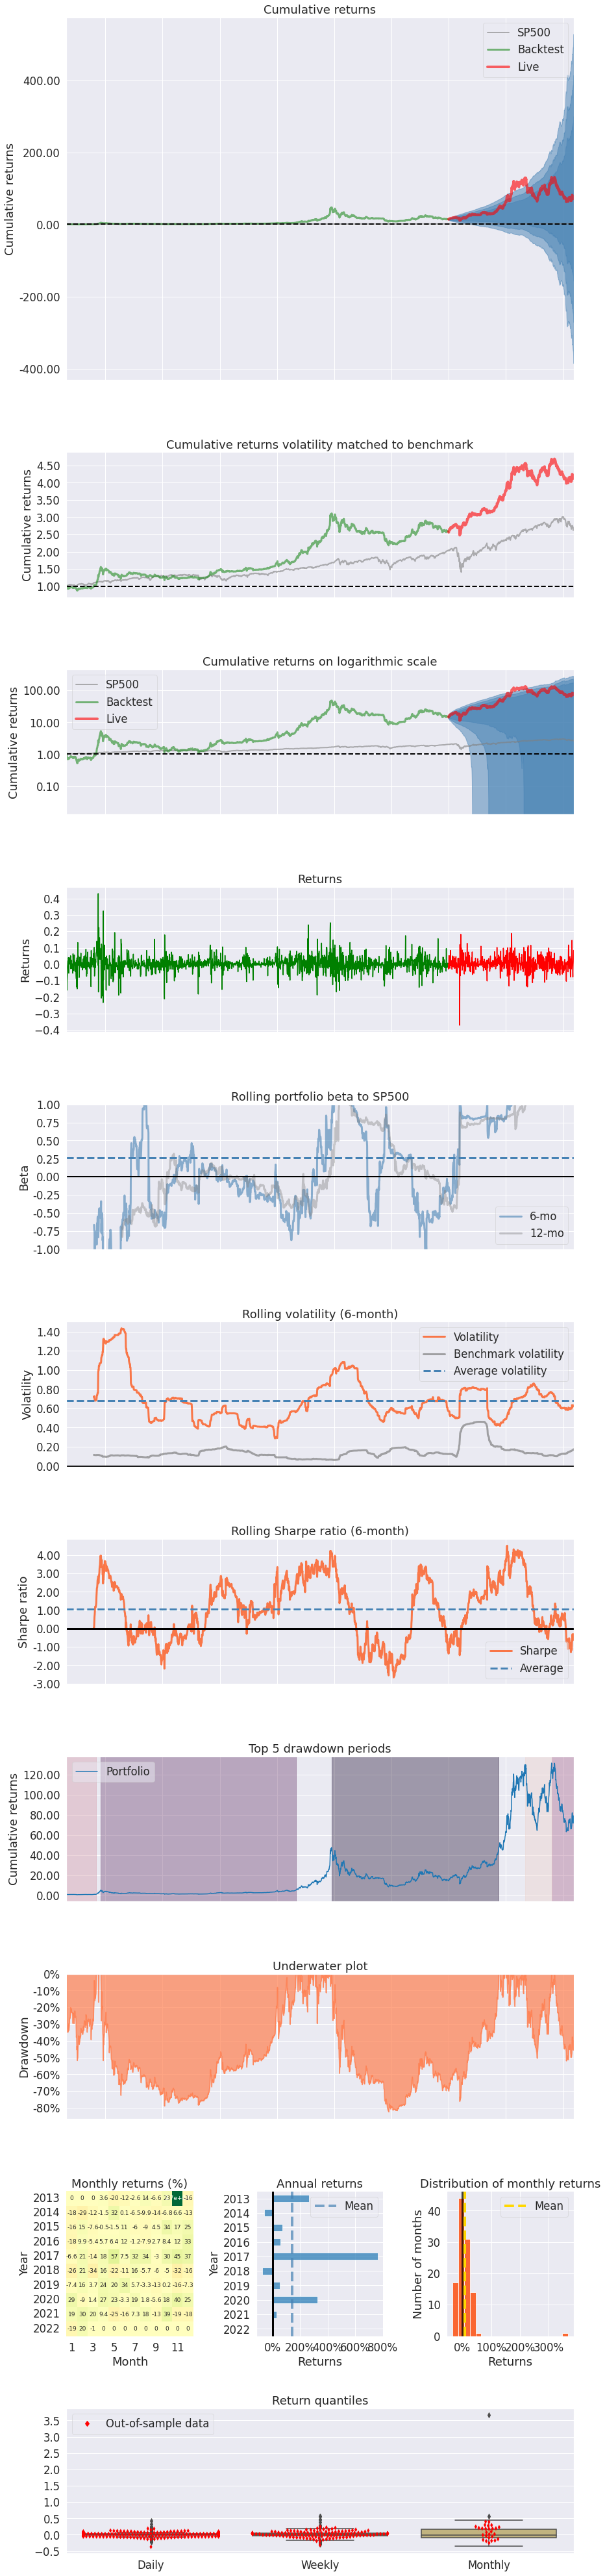

In [12]:
pf.create_returns_tear_sheet(btc_daily_return, benchmark_rets=sp500_daily_return, live_start_date='2020-01')
#pf.create_returns_tear_sheet(sp500_daily_return, benchmark_rets=btc_daily_return.squeeze())

## BTC vs. CoinIndex


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,84.53,2013-12-04,2015-01-14,2017-01-04,806
1,83.40,2017-12-16,2018-12-15,2020-11-30,771
2,53.06,2021-04-13,2021-07-20,2021-10-19,136
3,52.66,2013-04-29,2013-07-05,2013-10-15,122
4,48.15,2021-11-08,2022-01-22,NaT,NaN


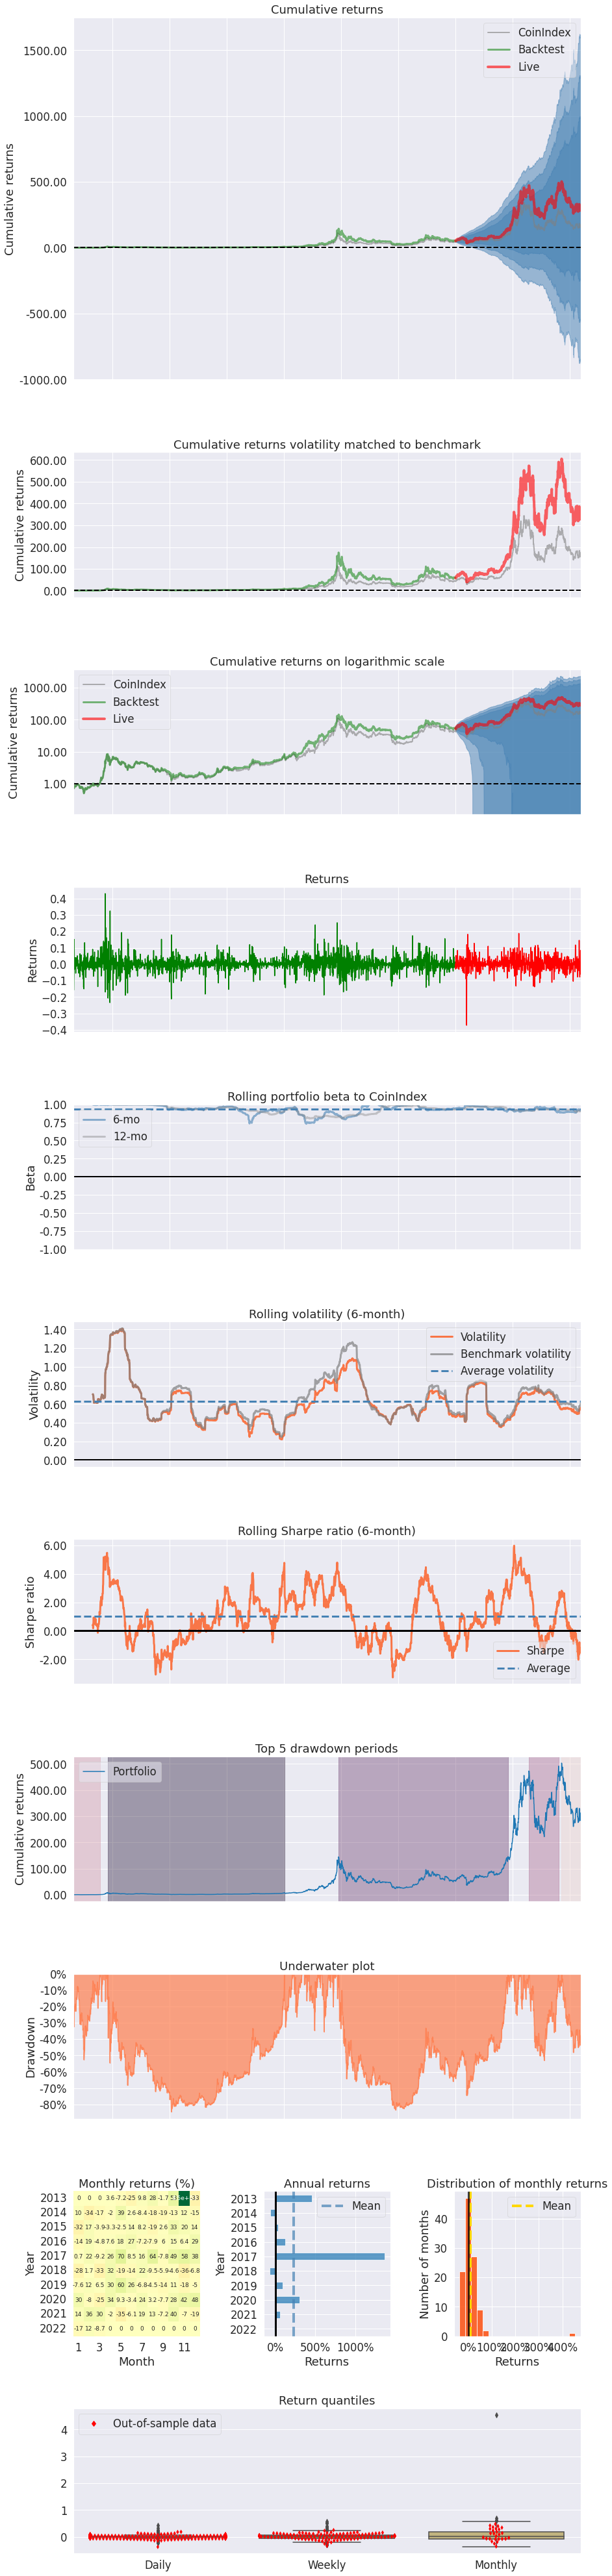

In [13]:
pf.create_returns_tear_sheet(btc_daily_return, benchmark_rets=weighted_coins_return, live_start_date='2020-01')